In [1]:
import pandas as pd
import numpy as np
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Particle class for PSO
class Particle:
    """
    Particle class for Particle Swarm Optimization.

    Each particle represents a potential solution (feature subset) for
    dimensionality reduction.
    """
    def __init__(self, n_features, max_features):
        """
        Initialize a particle with random position and velocity.

        Parameters:
        -----------
        n_features : int
            Total number of features in the dataset
        max_features : int
            Maximum number of features to select
        """
        # Initialize with random binary position (selected features)
        self.position = np.zeros(n_features)
        # Randomly select features (ensure at least 2 features are selected)
        n_selected = random.randint(2, max_features)
        selected_indices = random.sample(range(n_features), n_selected)
        self.position[selected_indices] = 1

        # Initialize velocity (probability of bit flipping)
        self.velocity = np.random.uniform(-1, 1, n_features)

        # Initialize best positions
        self.best_position = self.position.copy()
        self.best_fitness = -np.inf


In [3]:
# Function to evaluate feature subset
def evaluate_feature_subset(X, y, feature_indices, problem_type='regression'):
    """
    Evaluate a feature subset using multiple models.

    Parameters:
    -----------
    X : ndarray
        Feature matrix
    y : ndarray
        Target variable
    feature_indices : array-like
        Indices of selected features
    problem_type : str
        'regression' or 'classification'

    Returns:
    --------
    results : dict
        Performance metrics for each model
    """
    # Extract the selected features
    X_selected = X[:, feature_indices]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'SVM Regression': SVR(),
        'Random Forest': RandomForestRegressor(random_state=42, n_estimators=50),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=50)
    }

    results = {}

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        if problem_type == 'regression':
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            results[name] = {
                'R2': r2,
                'MAE': mae,
                'RMSE': rmse
            }
        else:  # classification
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')

            results[name] = {
                'Accuracy': accuracy,
                'F1': f1
            }

    return results


In [4]:
# PSO+GA Hybrid Algorithm for Feature Selection
class PsoGaFeatureSelection:
    """
    Hybrid PSO+GA algorithm for feature selection in dimensionality reduction.

    This algorithm combines Particle Swarm Optimization with Genetic Algorithm
    operators to efficiently search for optimal feature subsets.
    """
    def __init__(self, n_features, max_features=10, n_particles=20, w=0.7, c1=1.5, c2=1.5,
                 crossover_prob=0.7, mutation_prob=0.1, max_iter=50):
        """
        Initialize the PSO+GA hybrid algorithm.

        Parameters:
        -----------
        n_features : int
            Total number of features in the dataset
        max_features : int
            Maximum number of features to select
        n_particles : int
            Number of particles in the swarm
        w : float
            Inertia weight
        c1 : float
            Cognitive weight (personal best)
        c2 : float
            Social weight (global best)
        crossover_prob : float
            Probability of crossover operation
        mutation_prob : float
            Probability of mutation operation
        max_iter : int
            Maximum number of iterations
        """
        self.n_features = n_features
        self.max_features = max_features
        self.n_particles = n_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.max_iter = max_iter

        # Initialize particles
        self.particles = [Particle(n_features, max_features) for _ in range(n_particles)]

        # Initialize global best
        self.global_best_position = None
        self.global_best_fitness = -np.inf

        # For tracking progress
        self.best_fitness_history = []
        self.best_num_features_history = []

    def update_particle_velocity(self, particle):
        """
        Update the velocity of a particle based on PSO formula.

        Parameters:
        -----------
        particle : Particle
            The particle to update
        """
        # PSO velocity update formula: v = w*v + c1*r1*(pbest-x) + c2*r2*(gbest-x)
        r1 = np.random.random(self.n_features)
        r2 = np.random.random(self.n_features)

        cognitive_component = self.c1 * r1 * (particle.best_position - particle.position)
        social_component = self.c2 * r2 * (self.global_best_position - particle.position)

        particle.velocity = self.w * particle.velocity + cognitive_component + social_component

        # Clamp velocity to prevent explosion
        particle.velocity = np.clip(particle.velocity, -4, 4)

    def update_particle_position(self, particle):
        """
        Update the position of a particle using sigmoid function.

        Parameters:
        -----------
        particle : Particle
            The particle to update
        """
        # Convert velocity to probability using sigmoid function
        probability = 1 / (1 + np.exp(-particle.velocity))

        # Update position based on probability
        random_values = np.random.random(self.n_features)
        new_position = np.zeros(self.n_features)
        new_position[probability > random_values] = 1

        # Ensure at least 2 features are selected
        if np.sum(new_position) < 2:
            selected_indices = random.sample(range(self.n_features), 2)
            new_position = np.zeros(self.n_features)
            new_position[selected_indices] = 1

        # Apply GA-inspired mutation
        if random.random() < self.mutation_prob:
            mutation_idx = random.randint(0, self.n_features - 1)
            new_position[mutation_idx] = 1 - new_position[mutation_idx]

        # Ensure we don't exceed max_features
        if np.sum(new_position) > self.max_features:
            # Randomly deselect features until we're at max_features
            selected = np.where(new_position == 1)[0]
            to_remove = np.random.choice(selected, int(np.sum(new_position) - self.max_features), replace=False)
            new_position[to_remove] = 0

        particle.position = new_position

    def crossover(self, p1, p2):
        """
        Perform crossover between two particles (GA-inspired operation).

        Parameters:
        -----------
        p1, p2 : Particle
            The two particles to perform crossover on
        """
        if random.random() < self.crossover_prob:
            # Single-point crossover
            crossover_point = random.randint(1, self.n_features - 1)

            # Create child positions
            child1_pos = np.concatenate([p1.position[:crossover_point], p2.position[crossover_point:]])
            child2_pos = np.concatenate([p2.position[:crossover_point], p1.position[crossover_point:]])

            # Ensure minimum features
            if np.sum(child1_pos) < 2:
                selected_indices = random.sample(range(self.n_features), 2)
                child1_pos = np.zeros(self.n_features)
                child1_pos[selected_indices] = 1

            if np.sum(child2_pos) < 2:
                selected_indices = random.sample(range(self.n_features), 2)
                child2_pos = np.zeros(self.n_features)
                child2_pos[selected_indices] = 1

            # Ensure max features
            if np.sum(child1_pos) > self.max_features:
                selected = np.where(child1_pos == 1)[0]
                to_remove = np.random.choice(selected, int(np.sum(child1_pos) - self.max_features), replace=False)
                child1_pos[to_remove] = 0

            if np.sum(child2_pos) > self.max_features:
                selected = np.where(child2_pos == 1)[0]
                to_remove = np.random.choice(selected, int(np.sum(child2_pos) - self.max_features), replace=False)
                child2_pos[to_remove] = 0

            # Update positions
            p1.position = child1_pos
            p2.position = child2_pos

    def evaluate_fitness(self, position, X, y, problem_type='regression'):
        """
        Evaluate the fitness of a particle's position (feature subset).

        Parameters:
        -----------
        position : ndarray
            Binary array indicating selected features
        X : ndarray
            Feature matrix
        y : ndarray
            Target variable
        problem_type : str
            'regression' or 'classification'

        Returns:
        --------
        fitness : float
            Fitness score (higher is better)
        """
        # Convert binary position to feature indices
        feature_indices = np.where(position == 1)[0]

        if len(feature_indices) < 2:
            return -np.inf  # Penalize solutions with too few features

        # Evaluate the feature subset
        results = evaluate_feature_subset(X, y, feature_indices, problem_type)

        # Calculate fitness based on model performance
        if problem_type == 'regression':
            # Use average R2 score across all models as fitness
            avg_r2 = np.mean([results[model]['R2'] for model in results])
            # Include penalty for using more features
            feature_penalty = 0.01 * len(feature_indices) / self.n_features
            fitness = avg_r2 - feature_penalty
        else:
            # Use average accuracy for classification
            avg_acc = np.mean([results[model]['Accuracy'] for model in results])
            # Include penalty for using more features
            feature_penalty = 0.01 * len(feature_indices) / self.n_features
            fitness = avg_acc - feature_penalty

        return fitness

    def fit(self, X, y, problem_type='regression', verbose=True):
        """
        Run the PSO+GA hybrid algorithm to find the best feature subset.

        Parameters:
        -----------
        X : ndarray
            Feature matrix
        y : ndarray
            Target variable
        problem_type : str
            'regression' or 'classification'
        verbose : bool
            Whether to print progress

        Returns:
        --------
        best_features : list
            Indices of selected features
        """
        # Initialize global best position
        self.global_best_position = np.zeros(self.n_features)
        self.global_best_fitness = -np.inf

        start_time = time.time()

        # Evaluate initial particles
        for particle in self.particles:
            fitness = self.evaluate_fitness(particle.position, X, y, problem_type)

            # Update personal best
            if fitness > particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position.copy()

            # Update global best
            if fitness > self.global_best_fitness:
                self.global_best_fitness = fitness
                self.global_best_position = particle.position.copy()

        # Main loop
        for iteration in range(self.max_iter):
            # Update each particle
            for i in range(0, self.n_particles, 2):
                # Update velocity and position for first particle
                self.update_particle_velocity(self.particles[i])
                self.update_particle_position(self.particles[i])

                # Update velocity and position for second particle if available
                if i + 1 < self.n_particles:
                    self.update_particle_velocity(self.particles[i+1])
                    self.update_particle_position(self.particles[i+1])

                    # Apply crossover between pairs of particles (GA-inspired)
                    self.crossover(self.particles[i], self.particles[i+1])

            # Evaluate and update all particles
            for particle in self.particles:
                fitness = self.evaluate_fitness(particle.position, X, y, problem_type)

                # Update personal best
                if fitness > particle.best_fitness:
                    particle.best_fitness = fitness
                    particle.best_position = particle.position.copy()

                # Update global best
                if fitness > self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()

            # Track best fitness and number of features
            self.best_fitness_history.append(self.global_best_fitness)
            best_features = np.where(self.global_best_position == 1)[0]
            self.best_num_features_history.append(len(best_features))

            if verbose and (iteration % 5 == 0 or iteration == self.max_iter - 1):
                elapsed_time = time.time() - start_time
                print(f"Iteration {iteration+1}/{self.max_iter}, Best Fitness: {self.global_best_fitness:.4f}, "
                      f"Features: {len(best_features)}/{self.n_features}, "
                      f"Time: {elapsed_time:.2f}s")

        # Return the best feature subset
        best_features = np.where(self.global_best_position == 1)[0]
        return best_features.tolist()

    def plot_convergence(self):
        """Plot the convergence of the algorithm."""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.best_fitness_history)
        plt.title('Best Fitness over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(self.best_num_features_history)
        plt.title('Number of Selected Features over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Number of Features')
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [8]:
# Main program - integrating PSO+GA into the original pipeline
def main():
    # 1. Load the dataset
    data = pd.read_csv('/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned_sensor_data.csv')

    # Check if the first row contains indexes and adjust accordingly
    if data.iloc[0, 0] == '0' and 'timestamp' not in data.columns:
        # Create column names based on the sample provided
        column_names = ['index', 'timestamp']
        column_names.extend([f'sensor_{i:02d}' for i in range(52)])
        column_names.append('machine_status')

        # Load the data again with proper column names
        data = pd.read_csv('your_dataset.csv', names=column_names)

        # Drop the index column if it exists
        if 'index' in data.columns:
            data = data.drop('index', axis=1)

    # Display dataset info
    print(f"Dataset shape: {data.shape}")
    print(data.head())

    # Check for missing values
    missing_values = data.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])

    # Handle missing values
    # Note that sensor_15 has a very high number of missing values (220320)
    # We have a few options:
    # 1. Drop this column entirely
    # 2. Use a more sophisticated imputation method
    # 3. Use models that can handle missing values natively

    print("\nHandling missing values...")

    # Remove columns with extremely high missing values (e.g., >50% missing)
    cols_to_drop = []
    for col in data.columns:
        if col != 'machine_status' and col != 'timestamp':
            if data[col].isnull().sum() > len(data) * 0.5:
                cols_to_drop.append(col)

    print(f"Dropping columns with >50% missing values: {cols_to_drop}")
    data = data.drop(cols_to_drop, axis=1)

    # For remaining columns, use median imputation (fast and robust)
    if 'timestamp' in data.columns:
        X = data.drop(['timestamp', 'machine_status'], axis=1)
    else:
        X = data.drop(['machine_status'], axis=1)

    print("Using median imputation for remaining missing values...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # Convert back to DataFrame if needed
    X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)

    # Combine with the target variable and timestamp if needed
    if 'timestamp' in data.columns:
        result_data = pd.concat([data[['timestamp']], X_imputed_df, data[['machine_status']]], axis=1)
    else:
        result_data = pd.concat([X_imputed_df, data[['machine_status']]], axis=1)

    # Save the cleaned dataset to CSV
    output_path = "/content/drive/MyDrive/AAA_BE_Major_Proj/cleaned.csv"  # Replace with your desired path
    result_data.to_csv(output_path, index=False)
    print(f"Missing value handling complete. Cleaned dataset saved to {output_path}")

    # Convert back to DataFrame to keep column names
    X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

    # Encode the target variable if needed
    y = data['machine_status']
    if y.dtype == object:  # If the target is categorical
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        print(f"Encoded machine status: {dict(zip(le.classes_, range(len(le.classes_))))}")
    else:
        y_encoded = y

    # Split data for later evaluation
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
        X_imputed, y_encoded, test_size=0.3, random_state=42
    )

    # Sample the dataset if needed (for faster experimentation)
    # For our case, we'll use the full dataset for the PSO+GA algorithm
    sample_size = min(100, len(X_imputed))  # Limit to 100 samples for quick demonstration

    # Randomly sample the data
    indices = np.random.choice(X_imputed.shape[0], sample_size, replace=False)
    X_sample = X_imputed[indices]
    y_sample = y_encoded[indices]

    print(f"\nUsing sample size: {sample_size} for PSO+GA algorithm")

    # Initialize and run the PSO+GA algorithm
    start_time = time.time()

    # Set parameters for PSO+GA
    n_features = X_imputed.shape[1]
    max_features = min(20, n_features)  # Target max features to keep (adjust as needed)

    # Create the PSO+GA optimizer
    optimizer = PsoGaFeatureSelection(
        n_features=n_features,
        max_features=max_features,
        n_particles=30,
        w=0.7,
        c1=1.5,
        c2=1.5,
        crossover_prob=0.7,
        mutation_prob=0.1,
        max_iter=20  # Reduced for demonstration
    )

    # Find the best feature subset
    selected_features = optimizer.fit(X_sample, y_sample, problem_type='regression', verbose=True)

    pso_ga_time = time.time() - start_time

    # Get feature information
    feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'sensor_{i:02d}' for i in range(X_imputed.shape[1])]
    selected_feature_names = [feature_names[i] for i in selected_features]

    print(f"\nPSO+GA Feature Selection Results:")
    print(f"Original features: {X_train_full.shape[1]}")
    print(f"Reduced features: {len(selected_features)}")
    print(f"PSO+GA computation time: {pso_ga_time:.4f} seconds")
    print(f"Selected feature names: {selected_feature_names}")

    # Create reduced datasets for model evaluation
    X_train_pso_ga = X_train_full[:, selected_features]
    X_test_pso_ga = X_test_full[:, selected_features]

    # Define models for evaluation
    models = {
        'Linear Regression': LinearRegression(),
        'SVM Regression': SVR(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }

    # Train models on original dataset and calculate metrics
    original_results = {}
    original_times = {}

    for name, model in models.items():
        print(f"Training {name} on original dataset...")
        start_time = time.time()

        # Train model
        model.fit(X_train_full, y_train_full)

        # Make predictions
        y_pred = model.predict(X_test_full)

        # Calculate metrics
        r2 = r2_score(y_test_full, y_pred)
        mae = mean_absolute_error(y_test_full, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))

        train_time = time.time() - start_time

        original_results[name] = {
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        }
        original_times[name] = train_time

        print(f"{name} trained in {train_time:.4f} seconds")

    # Train models on reduced dataset and calculate metrics
    reduced_results = {}
    reduced_times = {}

    for name, model in models.items():
        print(f"Training {name} on reduced dataset...")
        start_time = time.time()

        # Train model
        model.fit(X_train_pso_ga, y_train_full)

        # Make predictions
        y_pred = model.predict(X_test_pso_ga)

        # Calculate metrics
        r2 = r2_score(y_test_full, y_pred)
        mae = mean_absolute_error(y_test_full, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))

        train_time = time.time() - start_time

        reduced_results[name] = {
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse
        }
        reduced_times[name] = train_time

        print(f"{name} trained in {train_time:.4f} seconds")

    # Display results
    print("\n--- DIMENSIONALITY REDUCTION RESULTS (PSO+GA) ---")
    print(f"a) Features Reduced: {X_train_full.shape[1]} -> {len(selected_features)} ({X_train_full.shape[1] - len(selected_features)} features removed)")
    print(f"b) PSO+GA Computation Time: {pso_ga_time:.4f} seconds")

    # Display R2 values for all models
    print("\nc) R-squared Values:")
    for name in models.keys():
        print(f"   {name}: Original = {original_results[name]['R2']:.4f}, Reduced (PSO+GA) = {reduced_results[name]['R2']:.4f}")

    # Display model accuracies (using R2 as accuracy metric for regression)
    print("\nd) Model Accuracy with Original Dataset (R2):")
    for name, result in original_results.items():
        print(f"   {name}: {result['R2']:.4f} (Training time: {original_times[name]:.4f} seconds)")

    print("\ne) Model Accuracy with PSO+GA Reduced Dataset (R2):")
    for name, result in reduced_results.items():
        print(f"   {name}: {result['R2']:.4f} (Training time: {reduced_times[name]:.4f} seconds)")

    # Create visualization for the results
    plt.figure(figsize=(12, 6))

    # Plot model performance comparison
    models_list = list(models.keys())
    original_r2 = [original_results[name]['R2'] for name in models_list]
    reduced_r2 = [reduced_results[name]['R2'] for name in models_list]

    x = np.arange(len(models_list))
    width = 0.35

    plt.subplot(1, 2, 1)
    plt.bar(x - width/2, original_r2, width, label='Original Dataset')
    plt.bar(x + width/2, reduced_r2, width, label='PSO+GA Reduced Dataset')
    plt.xlabel('Models')
    plt.ylabel('R² Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models_list, rotation=45)
    plt.legend()
    plt.tight_layout()

    # Plot PSO+GA convergence
    optimizer.plot_convergence()

    # Plot PSO feature selection - showing top selected features importance
    plt.subplot(1, 2, 2)
    if len(selected_features) > 0:
        # Use Random Forest to estimate feature importance of selected features
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train_pso_ga, y_train_full)

        # Get feature importances
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        top_n = min(10, len(selected_features))
        plt.barh(range(top_n), importances[indices[:top_n]])
        plt.yticks(range(top_n), [selected_feature_names[i] for i in indices[:top_n]])
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Selected Features by PSO+GA')
    else:
        plt.text(0.5, 0.5, "No features selected", ha='center', va='center')

    plt.tight_layout()
    plt.savefig('pso_ga_results.png')
    plt.show()

    # Summary table
    performance_summary = pd.DataFrame({
        'Original Dataset R²': original_r2,
        'PSO+GA Reduced Dataset R²': reduced_r2,
        'R² Difference': np.array(reduced_r2) - np.array(original_r2),
        'Original Training Time (s)': [original_times[name] for name in models_list],
        'PSO+GA Reduced Training Time (s)': [reduced_times[name] for name in models_list],
        'Time Savings (%)': [(1 - reduced_times[name]/original_times[name]) * 100 for name in models_list]
    }, index=models_list)

    print("\nPerformance Summary:")
    print(performance_summary)

    # Save results to CSV
    performance_summary.to_csv('pso_ga_performance_summary.csv')

    # Feature visualization for PSO+GA selected features
    plt.figure(figsize=(14, 10))

    # Visualize the distribution of selected vs non-selected features
    selected_mask = np.zeros(n_features, dtype=bool)
    selected_mask[selected_features] = True

    # Create a bar chart showing which features were selected
    plt.barh(range(n_features), selected_mask.astype(int), color='skyblue')
    plt.yticks(range(n_features), feature_names)
    plt.xlabel('Selected (1) / Not Selected (0)')
    plt.title('PSO+GA Feature Selection Results')
    plt.tight_layout()
    plt.savefig('pso_ga_feature_selection.png')
    plt.show()

    # Create a correlation matrix of selected features
    if len(selected_features) > 1:
        plt.figure(figsize=(12, 10))
        selected_data = X_imputed_df.iloc[:, selected_features]
        corr = selected_data.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix of PSO+GA Selected Features')
        plt.tight_layout()
        plt.savefig('pso_ga_feature_correlation.png')
        plt.show()



Dataset shape: (220320, 54)
             timestamp  Unnamed: 0  sensor_00  sensor_01  sensor_02  \
0  2018-04-01 00:00:00         0.0   2.465394   47.09201    53.2118   
1  2018-04-01 00:01:00         1.0   2.465394   47.09201    53.2118   
2  2018-04-01 00:02:00         2.0   2.444734   47.35243    53.2118   
3  2018-04-01 00:03:00         3.0   2.460474   47.09201    53.1684   
4  2018-04-01 00:04:00         4.0   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65

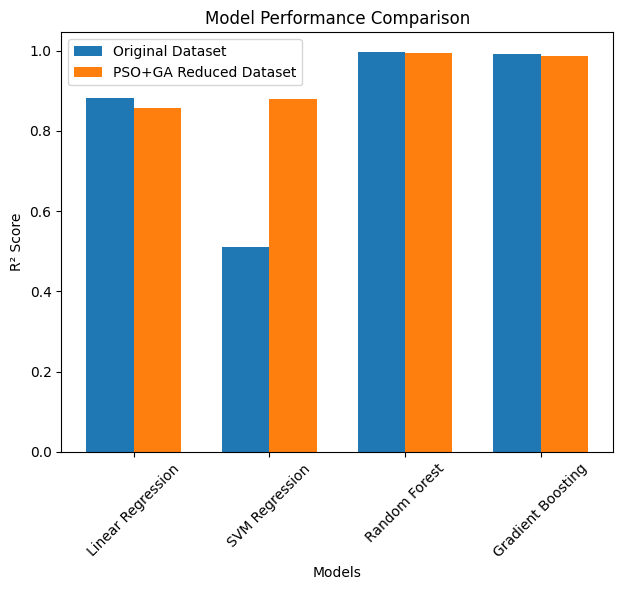

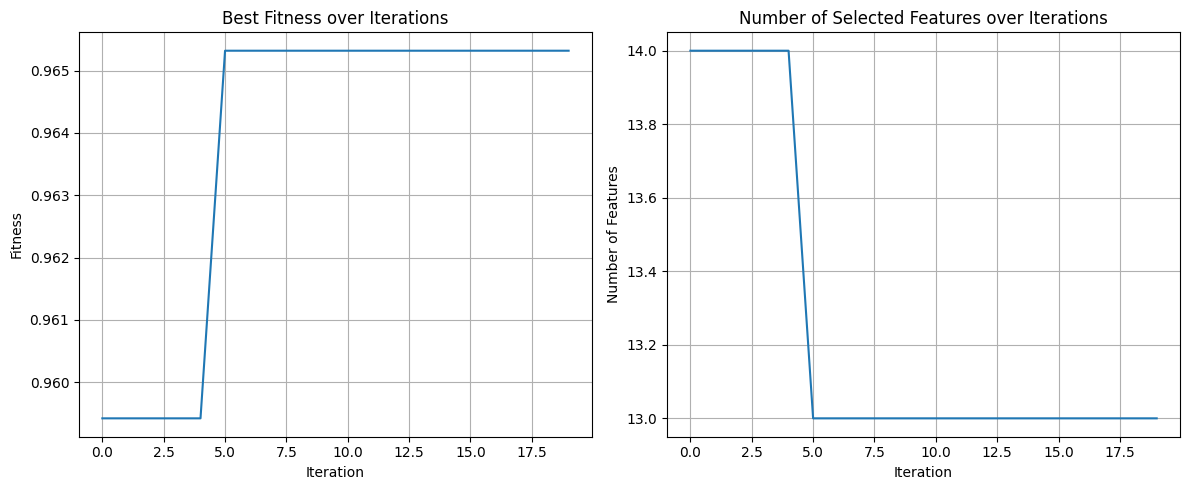

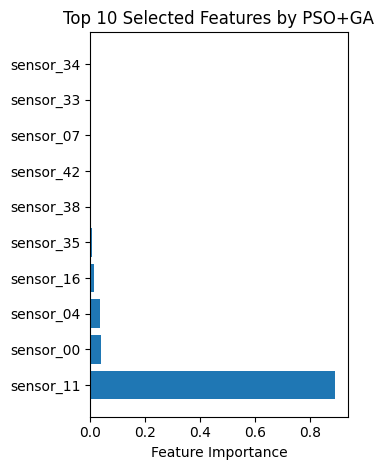


Performance Summary:
                   Original Dataset R²  PSO+GA Reduced Dataset R²  \
Linear Regression             0.882584                   0.857550   
SVM Regression                0.511465                   0.879594   
Random Forest                 0.995971                   0.995176   
Gradient Boosting             0.992306                   0.987831   

                   R² Difference  Original Training Time (s)  \
Linear Regression      -0.025033                    0.587992   
SVM Regression          0.368130                  642.052795   
Random Forest          -0.000795                  726.073756   
Gradient Boosting      -0.004475                  397.977057   

                   PSO+GA Reduced Training Time (s)  Time Savings (%)  
Linear Regression                          0.058802         89.999509  
SVM Regression                            79.823740         87.567418  
Random Forest                            121.727944         83.234769  
Gradient Boosting      

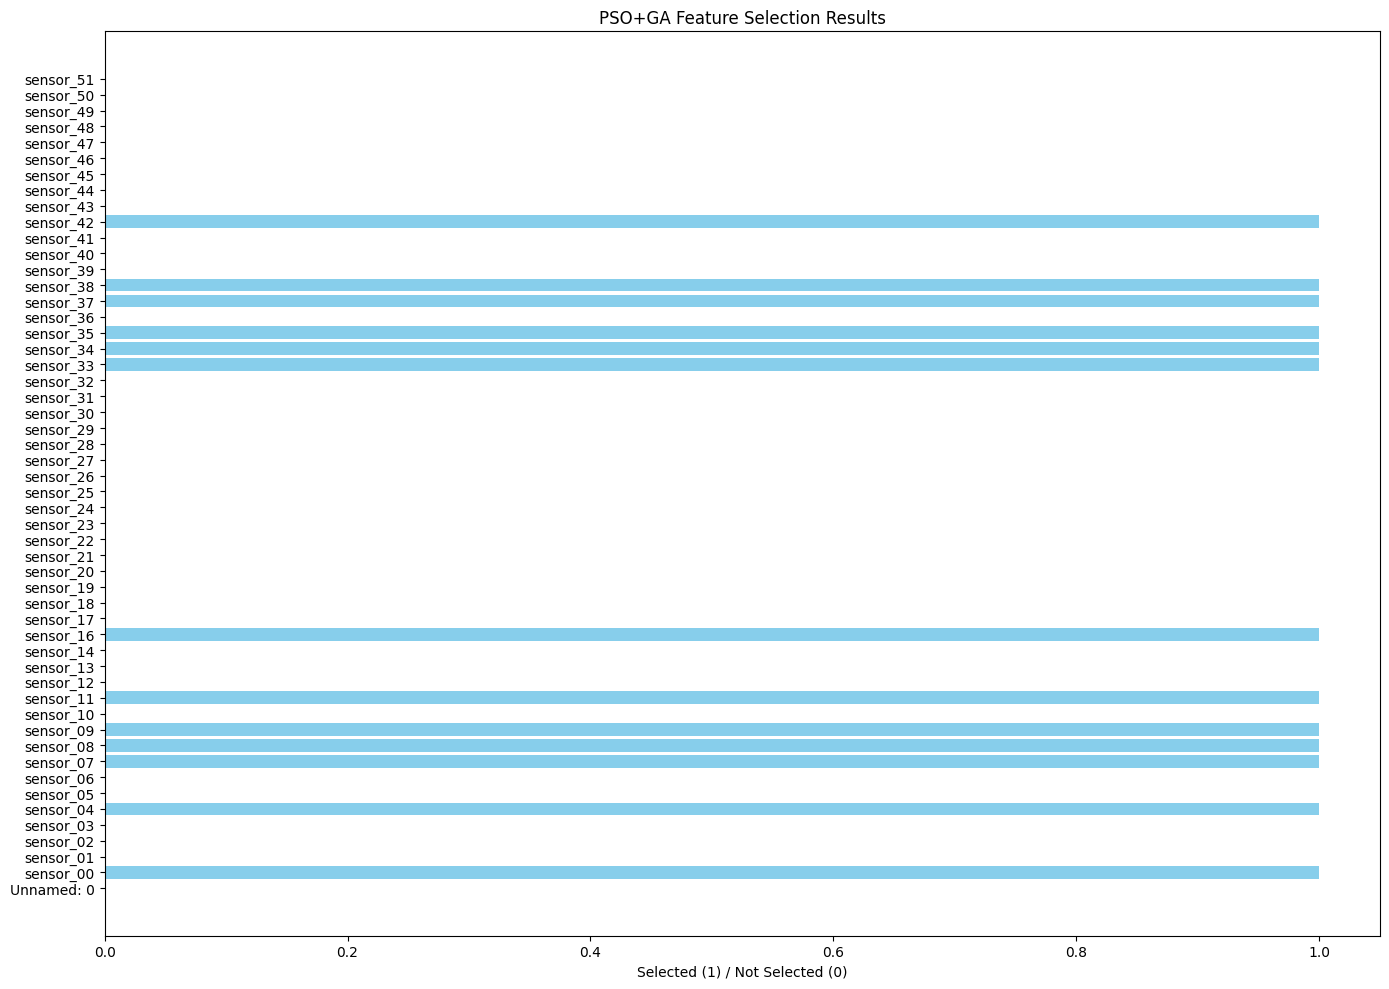

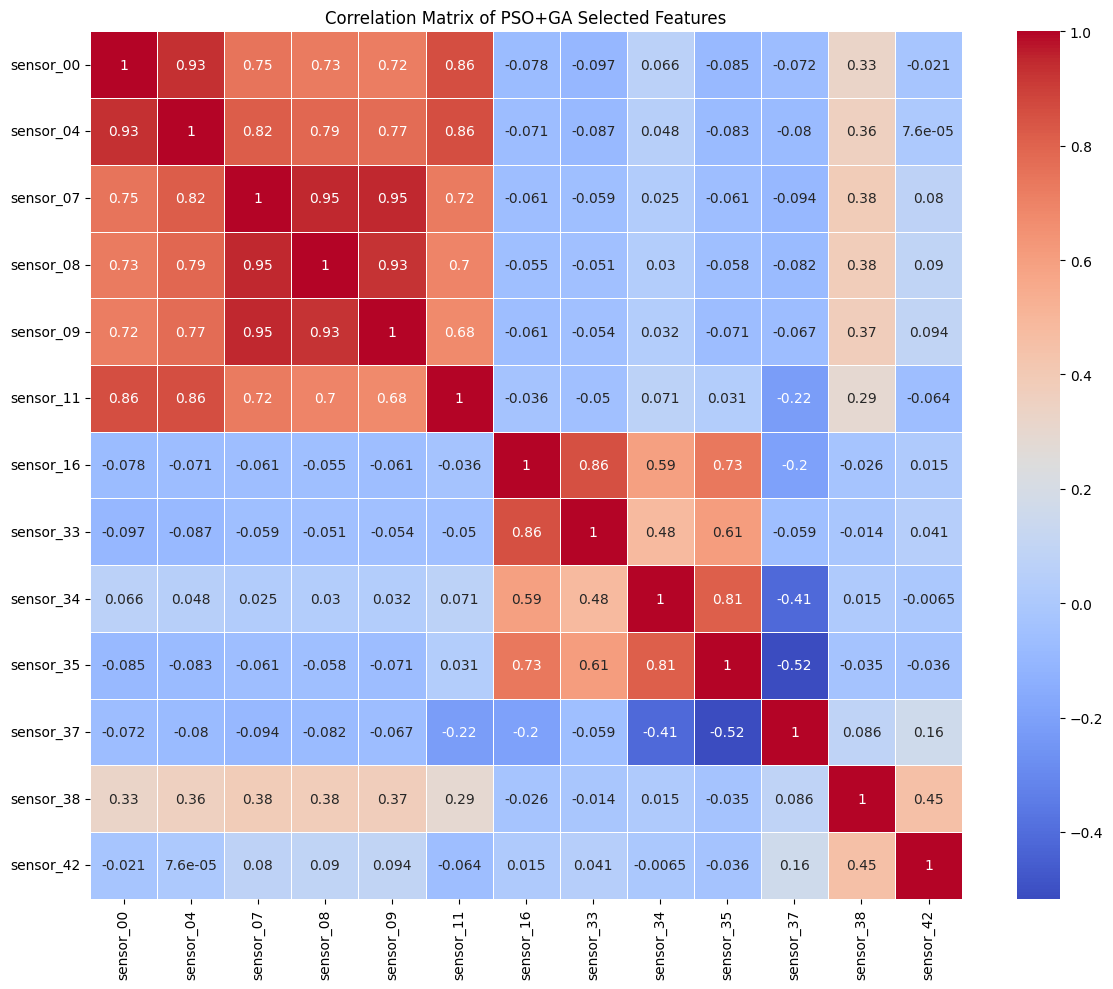

In [9]:
if __name__ == "__main__":
    main()